# Electricity Demand Forecasting

## Model Evaluation

For the final model evaluation we choose the best prophet model and evaluate
the model with out of sample data.  Because some of the exogeneous data is
weather related and we would not know the exact weather prior to the day we
will add some random variation to the data before using it for input to the
prediction portion of the model.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




In [1]:
import os
import sys

import numpy as np
import pandas as pd

import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser
import dateutil

from fbprophet import Prophet

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

In [2]:
# Read in the training and test data sets
X_train = pd.read_csv('../data/big_demand_temp_train.csv', index_col=0)
X_val = pd.read_csv('../data/big_demand_temp_validation.csv', index_col=0)

X_train.index = pd.DatetimeIndex(X_train.index)
X_val.index = pd.DatetimeIndex(X_val.index)

In [3]:
X_train.tail()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-03-31 19:00:00+00:00,21782,78.14,76.39,66.93,60.40,61.51,63.82,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 20:00:00+00:00,21851,81.11,79.76,69.05,62.56,64.24,67.47,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 21:00:00+00:00,21960,81.93,78.97,72.43,66.71,67.20,70.13,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 22:00:00+00:00,22742,82.54,77.68,74.24,67.60,70.43,72.52,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 23:00:00+00:00,23027,82.41,76.83,74.12,68.53,72.14,74.41,14173349.0,0,0,0,0,0,0,1,6


In [4]:
X_val.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-04-01 00:00:00+00:00,24233,81.03,76.26,73.87,65.30,73.42,75.23,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 01:00:00+00:00,25377,77.71,73.92,71.25,62.63,73.58,74.98,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 02:00:00+00:00,25263,74.85,71.90,68.08,60.05,73.29,73.82,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 03:00:00+00:00,26855,71.74,70.20,64.87,58.02,64.46,71.32,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 04:00:00+00:00,26907,70.26,69.32,61.56,57.41,67.34,67.98,14173349.0,1,0,0,0,0,0,0,0


Align the data frame to the start of a week

In [5]:
def agg_weekly(data_frame) :
    # Aggregate data on a weekly basis
    current_day = data_frame.index[0].date()
    row = data_frame.index[0]
    current_dow = data_frame.loc[row, 'DOW']
    week_demand = 0.0
    X_by_week = pd.DataFrame([], index=[current_day], \
        columns=['week_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])

    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop=0
    found_tue = False

    print(current_dow)
    for row in data_frame.index :
        next_dow = data_frame.loc[row].DOW
        if next_dow == 0 and found_tue == False :
            current_day = row.date()

        if next_dow == 1 :
            found_tue = 1

        if next_dow == 0 and found_tue :
            X_by_week.loc[current_day] = [week_demand, pop, \
                la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_dow = next_dow
            found_tue = False
            la_high = 0
            sd_high = 0
            f_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            pop=0
            week_demand = 0
        else :
            week_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
                
    X_by_week.loc[current_day] = [week_demand, pop, \
        la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]

                
    return X_by_week

In [6]:
# Aggregate data on a daily basis
def agg_daily(data_frame):
    current_day = data_frame.index[0].date()
    day_demand = 0.0
    X_by_day = pd.DataFrame([], index=[current_day], \
        columns=['day_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])
    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop = 0

    for row in data_frame.index :
        next_day = row.date()
        if next_day != current_day :
            X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                        sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_day = next_day
            la_high = 0
            sd_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            f_high = 0
            day_demand = 0
            pop=0
        else :
            day_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
    
    X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                sac_high, f_high, current_day.weekday()]
    
    return X_by_day

    

In [7]:
# drop all the rows before the start of the fisrt Monday
def find_week_start(data) :
    rows_to_drop = []
    for row in data.index :
        if data.loc[row, 'DOW'] != 0:
            rows_to_drop.append(row)
        else:
            break
            
    return rows_to_drop

In [8]:
X_val_daily = agg_daily(X_val)
X_train_daily = agg_daily(X_train)


In [9]:
X_train_daily.tail()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2019-03-27,603317,1.41733e+07,69.71,66.64,67.03,61.34,65.39,72.08,2
2019-03-28,612332,1.41733e+07,67.49,66.66,64.57,61.27,61.21,68.11,3
2019-03-29,609430,1.41733e+07,70.69,66.45,62.49,58.67,61.7,67.93,4
2019-03-30,589672,1.41733e+07,79.99,69.88,66.95,62.73,67.95,69.09,5
2019-03-31,554156,1.41733e+07,82.54,79.76,74.24,68.53,72.14,74.41,6


In [10]:
X_val_daily.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2019-04-01,626489,1.41733e+07,81.71,76.26,73.87,65.3,73.58,77.52,0
2019-04-02,639427,1.41733e+07,77.11,68.42,64.76,60.96,62.96,75.71,1
2019-04-03,637476,1.41733e+07,66.84,64.95,62.4,57.87,62.82,70.45,2
2019-04-04,637018,1.41733e+07,66.69,65.34,62.68,60.93,64.1,69.31,3
2019-04-05,610351,1.41733e+07,66.07,64.94,64.02,60.99,63.16,67.1,4


In [11]:
X_train_daily.rename({'day_demand' : 'y'}, axis=1, inplace=True)
X_train_daily['ds'] = X_train_daily.index
X_train_daily.index = pd.DatetimeIndex(X_train_daily.index)
X_train_daily.tail()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2019-03-27,603317,1.41733e+07,69.71,66.64,67.03,61.34,65.39,72.08,2,2019-03-27
2019-03-28,612332,1.41733e+07,67.49,66.66,64.57,61.27,61.21,68.11,3,2019-03-28
2019-03-29,609430,1.41733e+07,70.69,66.45,62.49,58.67,61.7,67.93,4,2019-03-29
2019-03-30,589672,1.41733e+07,79.99,69.88,66.95,62.73,67.95,69.09,5,2019-03-30
2019-03-31,554156,1.41733e+07,82.54,79.76,74.24,68.53,72.14,74.41,6,2019-03-31


In [12]:
X_val_daily.rename({'day_demand' : 'y'}, axis=1, inplace=True)
X_val_daily['ds'] = X_val_daily.index
X_val_daily.index = pd.DatetimeIndex(X_val_daily.index)

In [83]:
elec_df = X_train_daily.append(X_val_daily)
retype_cols = elec_df.columns[1:-1]
temp_df = elec_df[retype_cols].astype(float)
elec_df[retype_cols] = temp_df
elec_df.index = pd.DatetimeIndex(elec_df.index)
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1714 entries, 2015-07-01 to 2020-03-09
Data columns (total 10 columns):
y           1714 non-null object
CA_pop      1714 non-null float64
la_high     1714 non-null float64
sd_high     1714 non-null float64
sj_high     1714 non-null float64
sf_high     1714 non-null float64
sac_high    1714 non-null float64
f_high      1714 non-null float64
DOW         1714 non-null float64
ds          1714 non-null object
dtypes: float64(8), object(2)
memory usage: 147.3+ KB


Simulate a forecast

For the final demand prediction we need to provide temperature data.  Long term forecasts
are unreliable so I will use the observations in the current data to calculate a weekly
average for each city and use that for the future forecasted temperature.

In [84]:
def data_block(X, start, out_size) :
    # get the slices of data frames to provide the blocks requested
    block1 = X.iloc[start:start+out_size, :]
        
    return block1
    

In [85]:
elec_df['week_num'] = [x.isocalendar()[1] for x in elec_df.index]
week_temps_df = elec_df.groupby('week_num').mean()

In [86]:
# Make a date time index for dates starting at the end of the dataframe
start_date = elec_df.index[-1]
dti = pd.date_range(start_date, periods=365, freq='D')

In [87]:
future_df = pd.DataFrame(index=dti, columns=elec_df.columns[1:-1])
for col in future_df.columns[1:-1] :
    future_df[col] = [week_temps_df.loc[x.isocalendar()[1], col] for x in future_df.index]
    
future_df['CA_pop'] = [elec_df['CA_pop'].values[-1]] * future_df.shape[0]

future_df.index = pd.DatetimeIndex(future_df.index)
future_df['ds'] = future_df.index
future_df.head()

,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2020-03-09,14261874.0,73.273103,67.514483,68.253793,63.806897,68.332759,71.482414,2.896552,2020-03-09
2020-03-10,14261874.0,73.273103,67.514483,68.253793,63.806897,68.332759,71.482414,2.896552,2020-03-10
2020-03-11,14261874.0,73.273103,67.514483,68.253793,63.806897,68.332759,71.482414,2.896552,2020-03-11
2020-03-12,14261874.0,73.273103,67.514483,68.253793,63.806897,68.332759,71.482414,2.896552,2020-03-12
2020-03-13,14261874.0,73.273103,67.514483,68.253793,63.806897,68.332759,71.482414,2.896552,2020-03-13


Load the model

In [88]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_regressor('la_high')
m.add_regressor('sd_high')
m.add_regressor('f_high')
m.add_regressor('sj_high')
m.add_regressor('sf_high')
m.add_regressor('sac_high')
m.add_regressor('CA_pop')
model = m.fit(elec_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [96]:
forecast = m.predict(future_df)
forecast.index = pd.DatetimeIndex(forecast['ds'])

In [105]:
# Read out of sample data collected since analysis
new_demand = pd.read_csv('../data/new_demand.csv')
new_demand.index = pd.DatetimeIndex(new_demand['date'])
new_demand.head()

,date,demand
date,,
2020-03-09,2020-03-09,657675.0
2020-03-10,2020-03-10,694775.0
2020-03-11,2020-03-11,684014.0
2020-03-12,2020-03-12,692269.0
2020-03-13,2020-03-13,695167.0


/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



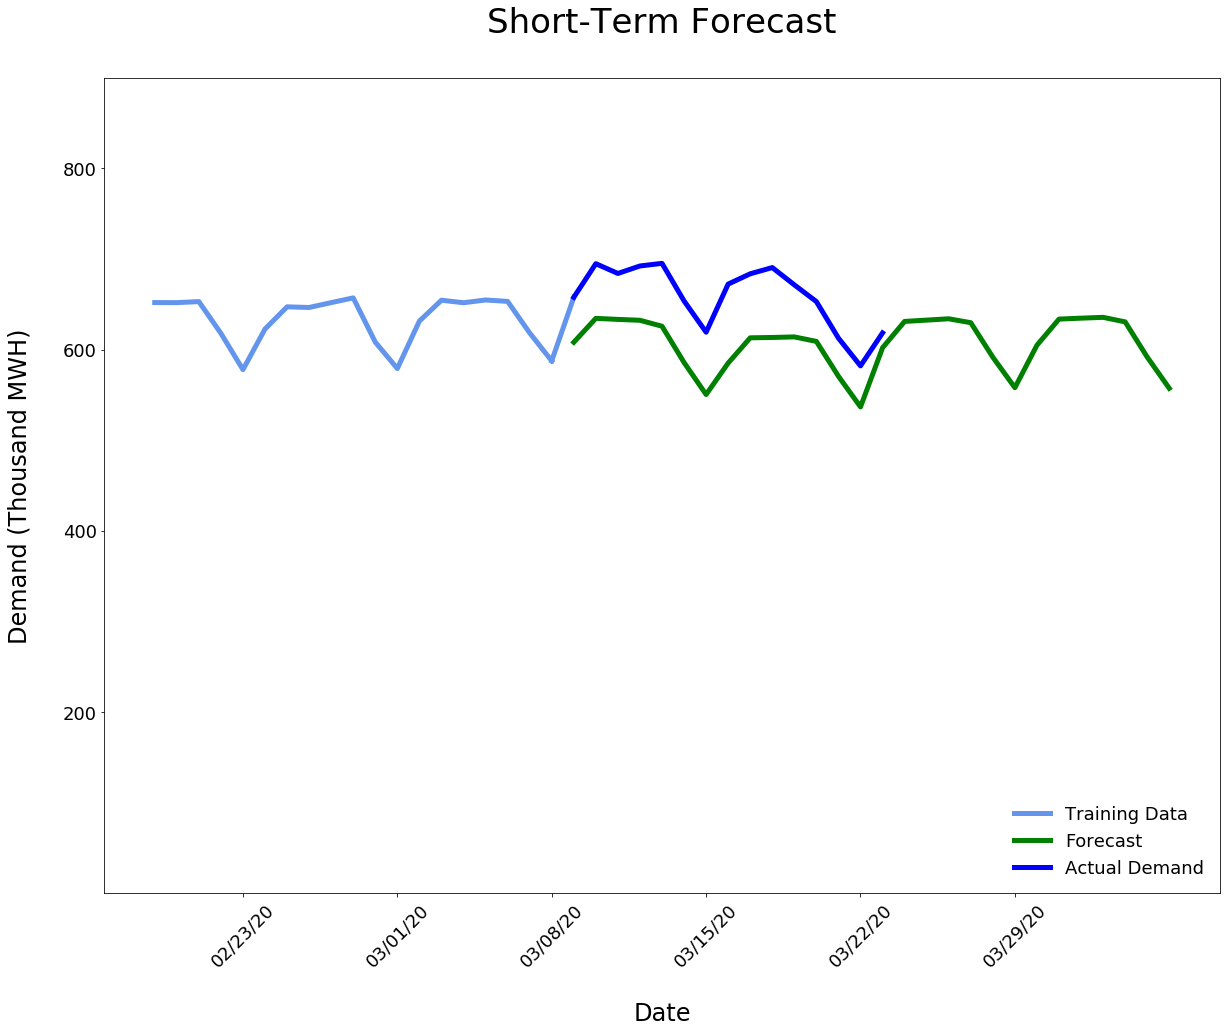

In [188]:
fig = plt.figure(figsize=[20, 15])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

xticks = pd.date_range('2-20-20', periods=6, freq='W')
xticks = [x.date() for x in xticks]
xlabels = [x.strftime('%x') for x in xticks]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks([200000, 400000, 600000, 800000], ['200', '400', '600', '800'])

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.ylim(0, 900000)


plt.title('Short-Term Forecast\n', fontsize=34)
plt.xlabel('\nDate')
plt.ylabel('Demand (Thousand MWH)\n')
plt.legend(loc='lower right')

plt.plot(elec_df.index[-20:-1], elec_df['y'].values[-20:-1], \
    c='cornflowerblue', label='Training Data', linewidth=5)
plt.plot([elec_df.index[-2], new_demand.index[0]], [elec_df['y'].values[-2],new_demand['demand'].values[0]], \
    c='cornflowerblue', linewidth=5)
plt.plot(forecast.index[:28], forecast['yhat'].values[:28], c='green', label='Forecast', linewidth=5)
plt.plot(new_demand.index[:-1], new_demand['demand'].values[:-1], c='b', label='Actual Demand', linewidth=5)
#plt.plot(X_val_daily.index[:28], X_val_daily['y'].values[:28], c='b', label='Validation Data', linewidth=2)
#plt.vlines(X_val_daily.index[0], 0, 1000000, color='r', linestyle = '--', label='Three Week Evaluation Period')
#plt.vlines(X_val_daily.index[21], 0, 1000000, color='r', linestyle = '--')



leg = plt.legend(loc='lower right', facecolor=None)
leg.get_frame().set_alpha(0.0)

plt.savefig('daily_demand_forecast_final.png', Transparent=True)

In [183]:
xticks

[datetime.date(2020, 2, 23),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 3, 8),
 datetime.date(2020, 3, 15),
 datetime.date(2020, 3, 22),
 datetime.date(2020, 3, 29)]

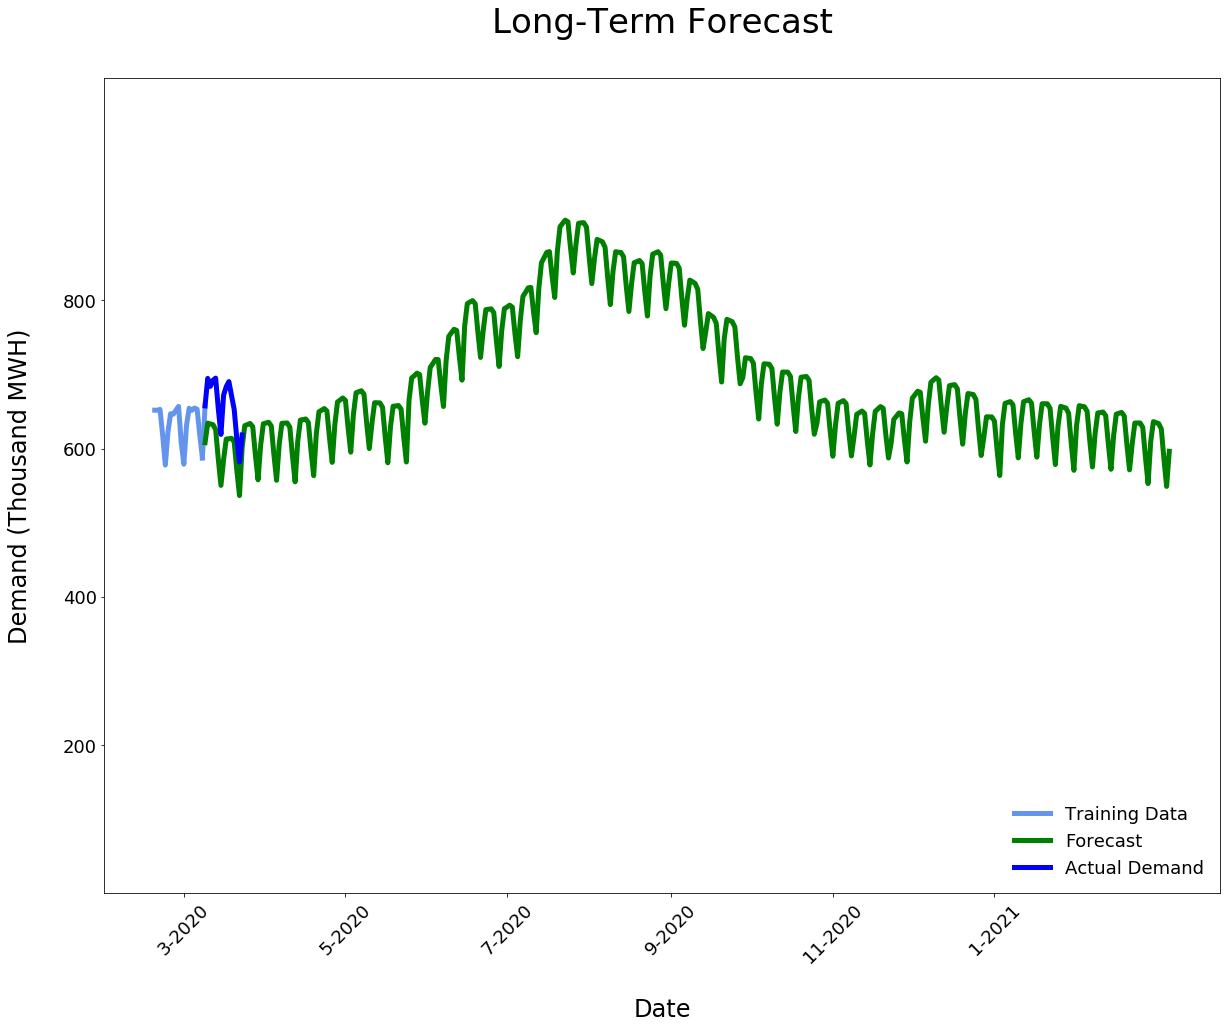

In [189]:
fig = plt.figure(figsize=[20, 15])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.ylim(0, 1100000)


SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

xticks = pd.date_range('2-29-20', periods=12, freq='M')
xticks = [x.date()+datetime.timedelta(days=1) for x in xticks[::2]]
xlabels = ['%d-%d' % (x.month, x.year) for x in xticks]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks([200000, 400000, 600000, 800000], ['200', '400', '600', '800'])

plt.title('Long-Term Forecast\n', fontsize='34')
plt.xlabel('\nDate')
plt.ylabel('Demand (Thousand MWH)\n')
plt.legend(loc='lower right')

plt.plot(elec_df.index[-20:-1], elec_df['y'].values[-20:-1], \
    c='cornflowerblue', label='Training Data', linewidth=5)
plt.plot([elec_df.index[-2], new_demand.index[0]], [elec_df['y'].values[-2],new_demand['demand'].values[0]], \
    c='cornflowerblue', linewidth=5)
plt.plot(forecast.index, forecast['yhat'].values, c='green', label='Forecast', linewidth=5)
plt.plot(new_demand.index[:-1], new_demand['demand'].values[:-1], c='b', label='Actual Demand', linewidth=5)
#plt.plot(X_val_daily.index[:28], X_val_daily['y'].values[:28], c='b', label='Validation Data', linewidth=2)
#plt.vlines(X_val_daily.index[0], 0, 1000000, color='r', linestyle = '--', label='Three Week Evaluation Period')
#plt.vlines(X_val_daily.index[21], 0, 1000000, color='r', linestyle = '--')


leg = plt.legend(loc='lower right', facecolor=None)
leg.get_frame().set_alpha(0.0)

plt.savefig('daily_demand_forecast_final_long.png', Transparent=True)